# Kyle Calabro
# DATA 750 - Thesis in Data Science
# 18 October 2021
---

# Notebook Seven w/ Filtered Images:
---
## Deploy transfer learning models for feature extraction on the augmented  training data, evaluate performance on testing data using image filtering techniques

In [1]:
!pip install fsspec
!pip install gcsfs

import librosa
import librosa.display

%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib.pyplot import specgram

import seaborn as sns

import IPython.display as ipd
from IPython.display import Audio

import seaborn as sns

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import sys
import warnings
import re

import time
import glob

from PIL import Image
from skimage import exposure, img_as_float

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.data import AUTOTUNE
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, InputLayer, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16, vgg19, InceptionV3, Xception, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# To ignore deprecation warnings...
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

np.random.seed(42)
#tf.random.set_random_seed(42)

     |████████████████████████████████| 132 kB 14.4 MB/s 
     |████████████████████████████████| 1.1 MB 18.6 MB/s 
     |████████████████████████████████| 271 kB 72.3 MB/s 
     |████████████████████████████████| 192 kB 65.7 MB/s 
     |████████████████████████████████| 160 kB 59.0 MB/s 


In [2]:
from google.colab import auth
auth.authenticate_user()

project_id = 'quantum-bonus-330300'
!gcloud config set project {project_id}
!gsutil ls

bucket_name = 'kpc_thesis'

Updated property [core/project].
gs://kpc_thesis/
gs://kpc_thesis_crema/


In [4]:
from google.colab import drive
drive._mount("/content/drive")

Mounted at /content/drive


In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Utility Functions
---

In [5]:
# Extracts features from images to save time in model training
# Params:
    # model: The model to predict with
    # input_ds: TF datasets to predict on
    
def get_bneck_features(model, input_ds):
    features = model.predict(input_ds, verbose = 0)
    return features

In [6]:
# To plot the accuracy of a CNN across epochs

def plot_accuracy(model_hist, model_title):
    plt.plot(model_hist.history["accuracy"])
    plt.plot(model_hist.history["val_accuracy"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc = "best")
    plt.show();

In [7]:
# To plot the loss of a CNN across epochs

def plot_loss(model_hist, model_title):
    plt.plot(model_hist.history["loss"])
    plt.plot(model_hist.history["val_loss"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(['Train', 'Test'], loc = "best")
    plt.show();

In [8]:
# To get the predicted labels of a given CNN model
# Params:
    # test_dataset: tf.data dataset containing image tensors and corresponding labels
    # model: the CNN model to make predictions with
    # encoder: The label encoder object used to encode labels initially

def get_predictions(test_dataset, model, encoder):
    y_pred = model.predict(test_dataset)
    y_pred = y_pred.argmax(axis = 1)
    y_pred = y_pred.astype(int).flatten()
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred

In [9]:
# To get the actual labels of a given CNN model
# Params:
    # y_test: target variable from the test set
    # encoder: The label encoder object used to encode labels initially

def get_labels(y_test, encoder):
    labels = y_test.argmax(axis = 1)
    labels = labels.astype(int).flatten()
    labels = encoder.inverse_transform(labels)
    return labels

In [10]:
# To print a classification report based on predictions from a CNN 
# and provided actual labels
# Params:
    # labels: The actual labels of the target variable
    # y_pred: The predicted labels of the target variable
    # encoder: The label encoder object used to encode labels initially
    
def get_report(labels, y_pred, encoder):
    target_names = encoder.classes_
    print(classification_report(labels, y_pred, target_names))

In [11]:
# To load an image from a Google Cloud Storage Bucket and convert to grayscale
# adjusting the contrast by a factor of two

# Params:
  # path: path to the image in the GCS bucket
  # label: the label corresponding to the image given by the path

def load_gs_ca2_images(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.rgb_to_grayscale(image)
  image = tf.image.grayscale_to_rgb(image)
  image = tf.image.adjust_contrast(image, 2)
  image = tf.cast(image, tf.float32) / 255.0

  return image, label

# Bringing in the Data
----

In [12]:
regex = re.compile(r"\d+")

In [13]:
# Generate list of files containing the training images from the bucket
train_files = tf.io.gfile.glob("gs://kpc_thesis/Aug_Train/*.jpeg")

# Get the metadata of the images
train_metadata = pd.read_csv("gs://kpc_thesis/Aug_Train/aug_train.csv")
train_metadata.columns.values[0] = "corresponding_id"

# Match the images to their appropriate labels
index_list = [regex.findall(file)[0] for file in train_files]
index_list = list(map(int, index_list))

train_labels = [train_metadata.Emotion.iloc[index] for index in index_list]

In [14]:
# Generate list of files containing the test images from the bucket
test_files = tf.io.gfile.glob("gs://kpc_thesis/Orig_Test/*.jpeg")

# Get the metadata of the images
test_metadata = pd.read_csv("gs://kpc_thesis/Orig_Test/orig_test_data.csv")
test_metadata.columns.values[0] = "corresponding_id"

# Match the images to their appropriate labels
index_list = [regex.findall(file)[0] for file in test_files]
index_list = list(map(int, index_list))

test_labels = [test_metadata.Emotion.iloc[index] for index in index_list]

In [15]:
print("Number of Training Labels:", len(train_labels))

Number of Training Labels: 9216


In [16]:
print("Number of Testing Labels:", len(test_labels))

Number of Testing Labels: 288


In [17]:
# One-hot encoding
encoder = LabelEncoder()

y_train = to_categorical(encoder.fit_transform(train_labels))
y_test = to_categorical(encoder.fit_transform(test_labels))

In [18]:
print(encoder.classes_)

['Angry' 'Calm' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']


In [19]:
# Create TF datasets from the images and corresponding labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((test_files, y_test))

In [20]:
train_dataset = (train_dataset.map(load_gs_ca2_images, num_parallel_calls = AUTOTUNE)
            .batch(32)
            .prefetch(AUTOTUNE))
train_dataset

<PrefetchDataset shapes: ((None, None, None, 3), (None, 8)), types: (tf.float32, tf.float32)>

In [21]:
test_dataset = (test_dataset.map(load_gs_ca2_images, num_parallel_calls = AUTOTUNE)
            .batch(32)
            .prefetch(AUTOTUNE))
test_dataset

<PrefetchDataset shapes: ((None, None, None, 3), (None, 8)), types: (tf.float32, tf.float32)>

In [22]:
# Define the input shape of the image tensors for the network
input_shape_orig = (217, 334, 3)

# VGG-16 Model Deployment as Feature Extractor
---

In [ ]:
def create_model():
  vgg = vgg16.VGG16(include_top = False, weights = "imagenet", input_shape = input_shape_orig)

  output = vgg.layers[-1].output
  output = keras.layers.Flatten()(output)
  vgg_model = Model(vgg.input, output)

  vgg_model.trainable = False

  for layer in vgg_model.layers:
    layer.trainable = False
  
  model = Sequential()
  input_shape = vgg_model.output_shape[1]

  vgg_train_features = get_bneck_features(vgg_model, train_dataset)
  vgg_test_features = get_bneck_features(vgg_model, test_dataset)

  model.add(InputLayer(input_shape = (input_shape,)))
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model, vgg_train_features, vgg_test_features

with tpu_strategy.scope():
  model, vgg_train_features, vgg_test_features = create_model()
  model.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               15729152  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 15,995,912
Trainable params: 15,995,912
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### Layers of the VGG-16 model are frozen, weights will not change during training

In [ ]:
print("Training Set Bottleneck Features:", vgg_train_features.shape)
print("Test Set Bottleneck Features:", vgg_test_features.shape)

Training Set Bottleneck Features: (9216, 30720)
Test Set Bottleneck Features: (288, 30720)


In [ ]:
start_time_model_1 = time.time()

model_1_hist = model.fit(x = vgg_train_features, y = y_train, batch_size = 32, epochs = 30, validation_data = (vgg_test_features, y_test), verbose = 1)

end_time_model_1 = time.time()

Epoch 1/30
288/288 [==============================] - 10s 18ms/step - loss: 1.8484 - accuracy: 0.3045 - val_loss: 1.5563 - val_accuracy: 0.4618
Epoch 2/30
288/288 [==============================] - 4s 16ms/step - loss: 1.5118 - accuracy: 0.4586 - val_loss: 1.3583 - val_accuracy: 0.5035
Epoch 3/30
288/288 [==============================] - 4s 15ms/step - loss: 1.3351 - accuracy: 0.5276 - val_loss: 1.2354 - val_accuracy: 0.5521
Epoch 4/30
288/288 [==============================] - 5s 16ms/step - loss: 1.1915 - accuracy: 0.5836 - val_loss: 1.1560 - val_accuracy: 0.5521
Epoch 5/30
288/288 [==============================] - 4s 15ms/step - loss: 1.0764 - accuracy: 0.6310 - val_loss: 1.0794 - val_accuracy: 0.5764
Epoch 6/30
288/288 [==============================] - 4s 15ms/step - loss: 0.9849 - accuracy: 0.6676 - val_loss: 1.0059 - val_accuracy: 0.6181
Epoch 7/30
288/288 [==============================] - 4s 16ms/step - loss: 0.8911 - accuracy: 0.7057 - val_loss: 0.9470 - val_accuracy: 0.638

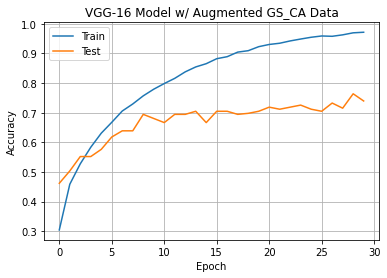

In [ ]:
plot_accuracy(model_1_hist, "VGG-16 Model w/ Augmented GS_CA Data")

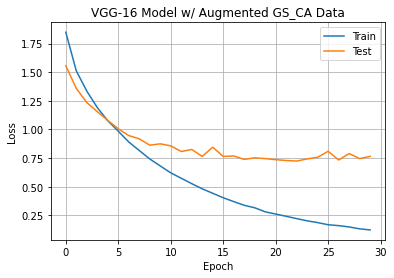

In [ ]:
plot_loss(model_1_hist, "VGG-16 Model w/ Augmented GS_CA Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_1 - start_time_model_1), "\n")

Elapsed Training Time: 158.9816529750824 seconds 



In [ ]:
model.evaluate(vgg_test_features, y_test)

9/9 [==============================] - 1s 10ms/step - loss: 0.7658 - accuracy: 0.7396


[0.7657822370529175, 0.7395833134651184]

In [ ]:
y_pred_model_1 = get_predictions(vgg_test_features, model, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_1, encoder)

              precision    recall  f1-score   support

       Angry       0.70      0.80      0.75        35
        Calm       0.75      0.92      0.83        36
     Disgust       0.84      0.79      0.82        39
        Fear       1.00      0.53      0.69        40
       Happy       0.64      0.64      0.64        36
     Neutral       0.64      0.67      0.65        24
         Sad       0.62      0.68      0.65        38
    Surprise       0.81      0.88      0.84        40

    accuracy                           0.74       288
   macro avg       0.75      0.74      0.73       288
weighted avg       0.76      0.74      0.74       288



In [ ]:
model.save("/content/drive/My Drive/Thesis/RAVDESS/VGG16_Aug_GS_CA_Data.h5")

# VGG-19 Deployment as Feature Extractor
---

In [ ]:
def create_model():
  vgg_19 = vgg19.VGG19(include_top = False, weights = "imagenet", input_shape = input_shape_orig)

  output = vgg_19.layers[-1].output
  output = keras.layers.Flatten()(output)
  vgg_19_model = Model(vgg_19.input, output)

  vgg_19_model.trainable = False

  for layer in vgg_19_model.layers:
    layer.trainable = False
  
  model = Sequential()
  input_shape = vgg_19_model.output_shape[1]

  vgg_19_train_features = get_bneck_features(vgg_19_model, train_dataset)
  vgg_19_test_features = get_bneck_features(vgg_19_model, test_dataset)

  model.add(InputLayer(input_shape = (input_shape,)))
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model, vgg_19_train_features, vgg_19_test_features

with tpu_strategy.scope():
  model_3, vgg_19_train_features, vgg_19_test_features = create_model()
  model_3.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_3.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               15729152  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 15,995,912
Trainable params: 15,995,912
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
print("Training Set Bottleneck Features:", vgg_19_train_features.shape)
print("Test Set Bottleneck Features:", vgg_19_test_features.shape)

Training Set Bottleneck Features: (9216, 30720)
Test Set Bottleneck Features: (288, 30720)


In [ ]:
start_time_model_3 = time.time()

model_3_hist = model_3.fit(x = vgg_19_train_features, y = y_train, batch_size = 32, epochs = 30, validation_data = (vgg_19_test_features, y_test), verbose = 1)

end_time_model_3 = time.time()

Epoch 1/30
288/288 [==============================] - 9s 19ms/step - loss: 1.8499 - accuracy: 0.3030 - val_loss: 1.6006 - val_accuracy: 0.4201
Epoch 2/30
288/288 [==============================] - 5s 17ms/step - loss: 1.5280 - accuracy: 0.4525 - val_loss: 1.4064 - val_accuracy: 0.5139
Epoch 3/30
288/288 [==============================] - 5s 16ms/step - loss: 1.3458 - accuracy: 0.5278 - val_loss: 1.2697 - val_accuracy: 0.5556
Epoch 4/30
288/288 [==============================] - 5s 16ms/step - loss: 1.2001 - accuracy: 0.5793 - val_loss: 1.2588 - val_accuracy: 0.5729
Epoch 5/30
288/288 [==============================] - 5s 16ms/step - loss: 1.0910 - accuracy: 0.6264 - val_loss: 1.0981 - val_accuracy: 0.6285
Epoch 6/30
288/288 [==============================] - 5s 16ms/step - loss: 0.9849 - accuracy: 0.6679 - val_loss: 1.0613 - val_accuracy: 0.6319
Epoch 7/30
288/288 [==============================] - 5s 16ms/step - loss: 0.9012 - accuracy: 0.6973 - val_loss: 1.0098 - val_accuracy: 0.6458

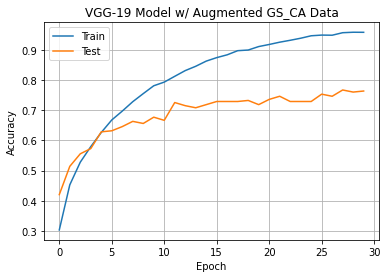

In [ ]:
plot_accuracy(model_3_hist, "VGG-19 Model w/ Augmented GS_CA Data")

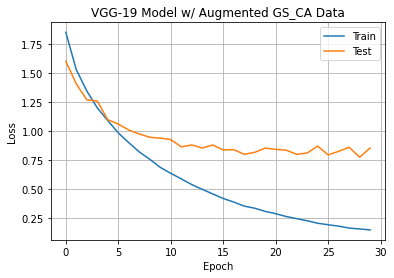

In [ ]:
plot_loss(model_3_hist, "VGG-19 Model w/ Augmented GS_CA Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_3 - start_time_model_3), "\n")

Elapsed Training Time: 155.96588516235352 seconds 



In [ ]:
model_3.evaluate(vgg_19_test_features, y_test)

9/9 [==============================] - 1s 11ms/step - loss: 0.8561 - accuracy: 0.7639


[0.8560766577720642, 0.7638888955116272]

In [ ]:
y_pred_model_3 = get_predictions(vgg_19_test_features, model_3, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_3, encoder)

              precision    recall  f1-score   support

       Angry       0.61      0.89      0.72        35
        Calm       0.86      0.83      0.85        36
     Disgust       0.84      0.82      0.83        39
        Fear       0.89      0.60      0.72        40
       Happy       0.80      0.56      0.66        36
     Neutral       0.80      0.83      0.82        24
         Sad       0.60      0.68      0.64        38
    Surprise       0.84      0.93      0.88        40

    accuracy                           0.76       288
   macro avg       0.78      0.77      0.76       288
weighted avg       0.78      0.76      0.76       288



In [ ]:
model_3.save("/content/drive/My Drive/Thesis/VGG19_GS_CA_Aug_Data.h5")

# InceptionV3 Deployment as Feature Extractor
---

In [ ]:
def create_model():
  inception = InceptionV3(weights = "imagenet", include_top = False, input_shape = input_shape_orig)

  output = inception.layers[-1].output
  output = Flatten()(output)
  inception_model = Model(inception.input, output)

  inception_model.trainable = False

  for layer in inception_model.layers:
    layer.trainable = False
  
  model = Sequential()
  input_shape = inception_model.output_shape[1]

  inception_train_features = get_bneck_features(inception_model, train_dataset)
  inception_test_features = get_bneck_features(inception_model, test_dataset)

  model.add(InputLayer(input_shape = (input_shape,)))
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model, inception_train_features, inception_test_features

#with tpu_strategy.scope():
model_4, inception_train_features, inception_test_features = create_model()
model_4.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_4.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               47186432  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 47,453,192
Trainable params: 47,453,192
Non-trainable params: 0
_____________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
start_time_model_4 = time.time()

model_4_hist = model_4.fit(x = inception_train_features, y = y_train, batch_size = 32, epochs = 30, validation_data = (inception_test_features, y_test), verbose = 1)

end_time_model_4 = time.time()

Epoch 1/30
288/288 [==============================] - 74s 255ms/step - loss: 1.6358 - accuracy: 0.3981 - val_loss: 1.3757 - val_accuracy: 0.5208
Epoch 2/30
288/288 [==============================] - 73s 255ms/step - loss: 1.1982 - accuracy: 0.5690 - val_loss: 1.2082 - val_accuracy: 0.5521
Epoch 3/30
288/288 [==============================] - 73s 255ms/step - loss: 0.9604 - accuracy: 0.6567 - val_loss: 1.1112 - val_accuracy: 0.5868
Epoch 4/30
288/288 [==============================] - 74s 258ms/step - loss: 0.7632 - accuracy: 0.7309 - val_loss: 1.0432 - val_accuracy: 0.6146
Epoch 5/30
288/288 [==============================] - 74s 256ms/step - loss: 0.6326 - accuracy: 0.7807 - val_loss: 1.1030 - val_accuracy: 0.6111
Epoch 6/30
288/288 [==============================] - 76s 263ms/step - loss: 0.4960 - accuracy: 0.8313 - val_loss: 1.0704 - val_accuracy: 0.6076
Epoch 7/30
288/288 [==============================] - 74s 258ms/step - loss: 0.4239 - accuracy: 0.8567 - val_loss: 1.0220 - val_ac

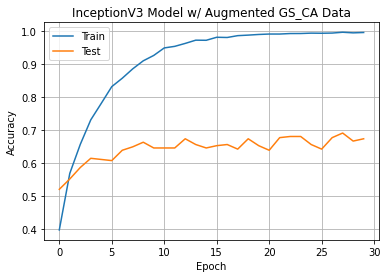

In [ ]:
plot_accuracy(model_4_hist, "InceptionV3 Model w/ Augmented GS_CA Data")

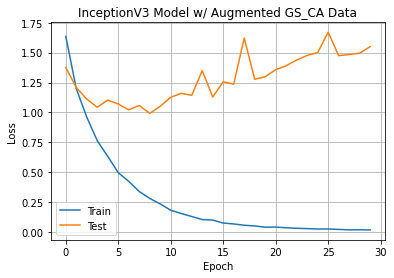

In [ ]:
plot_loss(model_4_hist, "InceptionV3 Model w/ Augmented GS_CA Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_4 - start_time_model_4), "\n")

Elapsed Training Time: 2220.9483313560486 seconds 



In [ ]:
model_4.evaluate(inception_test_features, y_test)

9/9 [==============================] - 0s 49ms/step - loss: 1.5504 - accuracy: 0.6736


[1.5503875017166138, 0.6736111044883728]

In [ ]:
y_pred_model_4 = get_predictions(inception_test_features, model_4, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_4, encoder)

              precision    recall  f1-score   support

       Angry       0.55      0.66      0.60        35
        Calm       0.67      0.78      0.72        36
     Disgust       0.70      0.67      0.68        39
        Fear       0.80      0.70      0.75        40
       Happy       0.61      0.56      0.58        36
     Neutral       0.58      0.62      0.60        24
         Sad       0.61      0.53      0.56        38
    Surprise       0.85      0.85      0.85        40

    accuracy                           0.67       288
   macro avg       0.67      0.67      0.67       288
weighted avg       0.68      0.67      0.67       288



In [ ]:
model_4.save("/content/drive/My Drive/Thesis/RAVDESS/InceptionV3_GS_CA_Aug_Data.h5")

# Xception Deployment as Feature Extractor
---

In [ ]:
def create_model():
  xception = Xception(weights = "imagenet", include_top = False, input_shape = input_shape_orig)

  output = xception.layers[-1].output
  output = Flatten()(output)
  xception_model = Model(xception.input, output)

  xception_model.trainable = False
  
  model = Sequential()
  input_shape = xception_model.output_shape[1]

  xception_train_features = get_bneck_features(xception_model, train_dataset)
  xception_test_features = get_bneck_features(xception_model, test_dataset)

  model.add(InputLayer(input_shape = (input_shape,)))
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model, xception_train_features, xception_test_features

#with tpu_strategy.scope():
model_5, xception_train_features, xception_test_features = create_model()
model_5.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_5.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               80740864  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 81,007,624
Trainable params: 81,007,624
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
print("Training Set Bottleneck Features:", xception_train_features.shape)
print("Test Set Bottleneck Features:", xception_test_features.shape)

Training Set Bottleneck Features: (9216, 157696)
Test Set Bottleneck Features: (288, 157696)


In [ ]:
start_time_model_5 = time.time()

model_5_hist = model_5.fit(x = xception_train_features, y = y_train, batch_size = 32, epochs = 30, validation_data = (xception_test_features, y_test), verbose = 1)

end_time_model_5 = time.time()

Epoch 1/30
288/288 [==============================] - 127s 438ms/step - loss: 1.4541 - accuracy: 0.4667 - val_loss: 1.2400 - val_accuracy: 0.5382
Epoch 2/30
288/288 [==============================] - 129s 446ms/step - loss: 1.0475 - accuracy: 0.6241 - val_loss: 1.0831 - val_accuracy: 0.6076
Epoch 3/30
288/288 [==============================] - 131s 455ms/step - loss: 0.8271 - accuracy: 0.7110 - val_loss: 0.9549 - val_accuracy: 0.6458
Epoch 4/30
288/288 [==============================] - 132s 459ms/step - loss: 0.6705 - accuracy: 0.7720 - val_loss: 0.9640 - val_accuracy: 0.6528
Epoch 5/30
288/288 [==============================] - 130s 453ms/step - loss: 0.5469 - accuracy: 0.8176 - val_loss: 0.9910 - val_accuracy: 0.6493
Epoch 6/30
288/288 [==============================] - 129s 449ms/step - loss: 0.4481 - accuracy: 0.8531 - val_loss: 0.8952 - val_accuracy: 0.6910
Epoch 7/30
288/288 [==============================] - 127s 441ms/step - loss: 0.3735 - accuracy: 0.8771 - val_loss: 0.9933 -

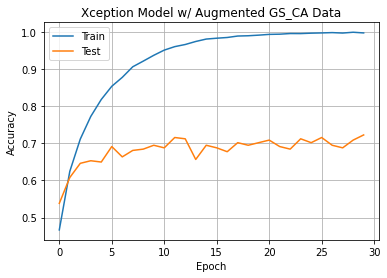

In [ ]:
plot_accuracy(model_5_hist, "Xception Model w/ Augmented GS_CA Data")

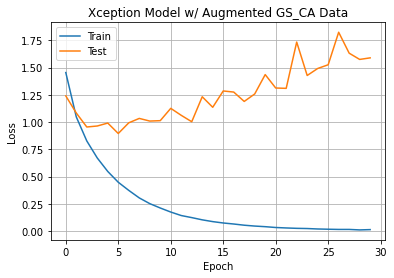

In [ ]:
plot_loss(model_5_hist, "Xception Model w/ Augmented GS_CA Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_5 - start_time_model_5), "\n")

Elapsed Training Time: 3811.8953051567078 seconds 



In [ ]:
model_5.evaluate(xception_test_features, y_test)

9/9 [==============================] - 1s 76ms/step - loss: 1.5889 - accuracy: 0.7222


[1.5888774394989014, 0.7222222089767456]

In [ ]:
y_pred_model_5 = get_predictions(xception_test_features, model_5, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_5, encoder)

              precision    recall  f1-score   support

       Angry       0.61      0.66      0.63        35
        Calm       0.64      0.94      0.76        36
     Disgust       0.73      0.85      0.79        39
        Fear       0.93      0.65      0.76        40
       Happy       0.69      0.75      0.72        36
     Neutral       0.67      0.50      0.57        24
         Sad       0.71      0.53      0.61        38
    Surprise       0.85      0.82      0.84        40

    accuracy                           0.72       288
   macro avg       0.73      0.71      0.71       288
weighted avg       0.74      0.72      0.72       288



In [ ]:
model_5.save("/content/drive/My Drive/Thesis/RAVDESS/Xception_GS_CA_Orig_Data.h5")

# ResNet-50 Deployment as Feature Extractor
---

In [23]:
def create_model():
  resnet = ResNet50(weights = "imagenet", include_top = False, input_shape = input_shape_orig)

  output = resnet.layers[-1].output
  output = Flatten()(output)
  resnet_model = Model(resnet.input, output)

  resnet_model.trainable = False

  model = Sequential()
  input_shape = resnet_model.output_shape[1]
  
  resnet_train_features = get_bneck_features(resnet_model, train_dataset)
  resnet_test_features = get_bneck_features(resnet_model, test_dataset)

  input_shape = resnet_model.output_shape[1]

  model.add(InputLayer(input_shape = (input_shape,)))
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model, resnet_train_features, resnet_test_features

#with tpu_strategy.scope():
model_6, resnet_train_features, resnet_test_features = create_model()
model_6.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_6.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               80740864  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 81,007,624
Trainable params: 81,007,624
Non-trainable params: 0
_____________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [24]:
print("Training Set Bottleneck Features:", resnet_train_features.shape)
print("Test Set Bottleneck Features:", resnet_test_features.shape)

Training Set Bottleneck Features: (9216, 157696)
Test Set Bottleneck Features: (288, 157696)


In [25]:
start_time_model_6 = time.time()

model_6_hist = model_6.fit(x = resnet_train_features, y = y_train, batch_size = 32, epochs = 30, validation_data = (resnet_test_features, y_test), verbose = 1)

end_time_model_6 = time.time()

Epoch 1/30
288/288 [==============================] - 123s 425ms/step - loss: 2.0227 - accuracy: 0.2123 - val_loss: 1.8664 - val_accuracy: 0.3229
Epoch 2/30
288/288 [==============================] - 123s 428ms/step - loss: 1.8799 - accuracy: 0.2688 - val_loss: 1.7739 - val_accuracy: 0.3750
Epoch 3/30
288/288 [==============================] - 123s 427ms/step - loss: 1.8126 - accuracy: 0.3156 - val_loss: 1.7501 - val_accuracy: 0.3924
Epoch 4/30
288/288 [==============================] - 124s 431ms/step - loss: 1.7538 - accuracy: 0.3448 - val_loss: 1.6891 - val_accuracy: 0.3993
Epoch 5/30
288/288 [==============================] - 123s 429ms/step - loss: 1.7076 - accuracy: 0.3558 - val_loss: 1.6480 - val_accuracy: 0.4132
Epoch 6/30
288/288 [==============================] - 121s 419ms/step - loss: 1.6636 - accuracy: 0.3741 - val_loss: 1.6392 - val_accuracy: 0.4097
Epoch 7/30
288/288 [==============================] - 121s 421ms/step - loss: 1.6249 - accuracy: 0.3949 - val_loss: 1.6153 -

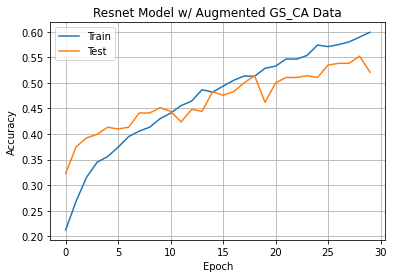

In [26]:
plot_accuracy(model_6_hist, "Resnet Model w/ Augmented GS_CA Data")

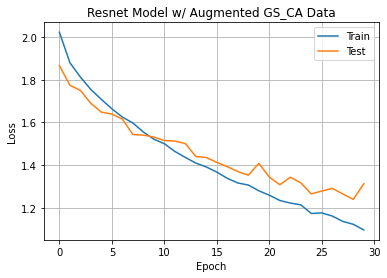

In [27]:
plot_loss(model_6_hist, "Resnet Model w/ Augmented GS_CA Data")

In [28]:
print("Elapsed Training Time: {} seconds".format(end_time_model_6 - start_time_model_6), "\n")

Elapsed Training Time: 3660.4176144599915 seconds 



In [29]:
model_6.evaluate(resnet_test_features, y_test)

9/9 [==============================] - 1s 75ms/step - loss: 1.3124 - accuracy: 0.5208


[1.312370777130127, 0.5208333134651184]

In [30]:
y_pred_model_6 = get_predictions(resnet_test_features, model_6, encoder)

In [31]:
y_labels = get_labels(y_test, encoder)

In [32]:
get_report(y_labels, y_pred_model_6, encoder)

              precision    recall  f1-score   support

       Angry       0.66      0.60      0.63        35
        Calm       0.42      0.89      0.57        36
     Disgust       0.62      0.77      0.69        39
        Fear       0.71      0.25      0.37        40
       Happy       0.31      0.28      0.29        36
     Neutral       0.44      0.29      0.35        24
         Sad       0.31      0.24      0.27        38
    Surprise       0.76      0.78      0.77        40

    accuracy                           0.52       288
   macro avg       0.53      0.51      0.49       288
weighted avg       0.54      0.52      0.50       288



In [33]:
model_6.save("/content/drive/My Drive/Thesis/RAVDESS/Resnet_GS_CA_Aug_Data.h5")

# AlexNet
---


In [ ]:
def create_model():
  #Instantiation
  AlexNet = Sequential()

  #1st Convolutional Layer
  AlexNet.add(Conv2D(filters = 96, input_shape = input_shape_orig, kernel_size = (11,11), strides = (4, 4), padding = "same"))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same'))

  #2nd Convolutional Layer
  AlexNet.add(Conv2D(filters = 256, kernel_size = (5, 5), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

  #3rd Convolutional Layer
  AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))

  #4th Convolutional Layer
  AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))

  #5th Convolutional Layer
  AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

  #Passing it to a Fully Connected layer
  AlexNet.add(Flatten())
  # 1st Fully Connected Layer
  AlexNet.add(Dense(512, input_shape=input_shape_orig))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  # Add Dropout to prevent overfitting
  AlexNet.add(Dropout(0.4))

  #2nd Fully Connected Layer
  AlexNet.add(Dense(512))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  #Add Dropout
  AlexNet.add(Dropout(0.4))

  #3rd Fully Connected Layer
  AlexNet.add(Dense(256))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  #Add Dropout
  AlexNet.add(Dropout(0.4))

  #Output Layer
  AlexNet.add(Dense(8))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('softmax'))

  return AlexNet

In [ ]:
with tpu_strategy.scope():
  AlexNet = create_model()
  AlexNet.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])
  
AlexNet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 84, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 84, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 84, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 42, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 42, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 28, 42, 256)     

In [ ]:
lrr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = .01, patience = 3, min_lr = 1e-5) 

In [ ]:
start_time_alexnet = time.time()

alexnet_hist = AlexNet.fit(train_dataset, epochs = 30, validation_data = test_dataset, callbacks = [lrr], verbose = 1)

end_time_alexnet = time.time()

Epoch 1/30
288/288 [==============================] - 196s 619ms/step - loss: 1.9744 - accuracy: 0.2456 - val_loss: 1.9201 - val_accuracy: 0.3403 - lr: 0.0010
Epoch 2/30
288/288 [==============================] - 194s 674ms/step - loss: 1.7823 - accuracy: 0.3226 - val_loss: 2.9307 - val_accuracy: 0.2292 - lr: 0.0010
Epoch 3/30
288/288 [==============================] - 196s 680ms/step - loss: 1.6892 - accuracy: 0.3590 - val_loss: 1.8899 - val_accuracy: 0.3056 - lr: 0.0010
Epoch 4/30
288/288 [==============================] - 232s 805ms/step - loss: 1.5977 - accuracy: 0.3958 - val_loss: 2.9621 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 5/30
288/288 [==============================] - 203s 703ms/step - loss: 1.5281 - accuracy: 0.4290 - val_loss: 1.2548 - val_accuracy: 0.5556 - lr: 1.0000e-05
Epoch 6/30
288/288 [==============================] - 200s 693ms/step - loss: 1.5046 - accuracy: 0.4404 - val_loss: 1.2429 - val_accuracy: 0.5625 - lr: 1.0000e-05
Epoch 7/30
288/288 [==================

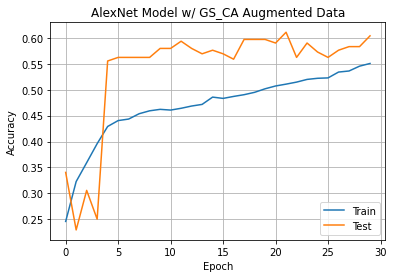

In [ ]:
plot_accuracy(alexnet_hist, "AlexNet Model w/ GS_CA Augmented Data")

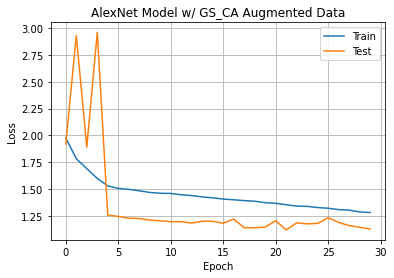

In [ ]:
plot_loss(alexnet_hist, "AlexNet Model w/ GS_CA Augmented Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_alexnet - start_time_alexnet), "\n")

Elapsed Training Time: 6170.69323682785 seconds 



In [ ]:
AlexNet.evaluate(test_dataset)

9/9 [==============================] - 7s 653ms/step - loss: 1.1259 - accuracy: 0.6042


[1.1258543729782104, 0.6041666865348816]

In [ ]:
y_pred_alexnet = get_predictions(test_dataset, AlexNet, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_alexnet, encoder)

              precision    recall  f1-score   support

       Angry       0.72      0.66      0.69        35
        Calm       0.72      0.78      0.75        36
     Disgust       0.74      0.82      0.78        39
        Fear       0.88      0.35      0.50        40
       Happy       0.56      0.28      0.37        36
     Neutral       0.71      0.42      0.53        24
         Sad       0.37      0.50      0.43        38
    Surprise       0.51      0.95      0.66        40

    accuracy                           0.60       288
   macro avg       0.65      0.59      0.59       288
weighted avg       0.65      0.60      0.59       288



In [ ]:
AlexNet.save("/content/drive/My Drive/Thesis/RAVDESS/AlexNet_GS_CA_Aug_Data.h5")